# Plot ensembles of rainfall maps 

In [6]:
%matplotlib inline
from netCDF4 import Dataset as nc, num2date
import pandas as pd
import xarray as xr
import numpy as np
from glob import glob
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from matplotlib import cm
import os
import sys
import pytz
from datetime import datetime, timedelta
from cross_sect import getCrossSection, haversine
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

### Define the input netCDF data
First define the experiment setup to construct the input files. The Experiment setup contains the following info:
 * domain_name = Where took the experiment place
 * exp_id       = What is the parametrization setup
 * init_time    = The time of initialisation
 * res          = The spatial resolution
 
Then define all the input-fields, where they are stored and the variable names
Also define the Experiment-setup to 

In [80]:
datadir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
domain_name = 'darwin'
exp_id = 'RA1T'
res = '0p44km'
modeldir = []
umf = {}
init_t = {}
init = ('20061110T0000Z', '20061110T0600Z',  '20061110T1200Z',  '20061110T1800Z',  '20061111T0000Z',  '20061111T1200Z',  '20061117T0000Z',  '20061117T1200Z')
for t in ('rain',):
    umf[t] = []
    init_t[t] = []
    for init_time in init:
        modeldir.append(os.path.join(datadir, domain_name, exp_id, init_time, domain_name, res))
        date = datetime.strptime(init_time,'%Y%m%dT%H%MZ')
        fname = 'um-%s-%s-%s_*.nc'%(res, date.strftime('%m%d%H%M'), t)
        try:
            umf[t].append(glob(os.path.join(modeldir[-1],fname))[0])
            init_t[t].append(date.strftime('UM %F %HUTC'))
            
        except IndexError:
            pass
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
cpolF = os.path.join(datadir,'CPOL_2p5km_2006111000-2006111823.nc')

In [81]:
init_t

{'rain': ['UM 2006-11-10 00UTC',
  'UM 2006-11-10 06UTC',
  'UM 2006-11-10 12UTC',
  'UM 2006-11-10 18UTC',
  'UM 2006-11-11 00UTC',
  'UM 2006-11-11 12UTC']}

### Read the data with xarray define the smalest common area and get the common time-steps

In [82]:
datasets = [xr.open_dataset(cpolF)]

In [83]:
um_tmp = []
for member in umf['rain']:
    um_tmp.append((member,xr.open_dataset(member)))

In [84]:
for fname, f in um_tmp:
    with nc(fname) as ncf:
        try:
            T=pd.DatetimeIndex(num2date(ncf.variables['time'][:],ncf.variables['time'].units)).round('10min')
        except KeyError:
            T=pd.DatetimeIndex(num2date(ncf.variables['t'][:],ncf.variables['t'].units)).round('10min')
        f['t'] = T
    datasets.append(f)

In [127]:
lons, lats, times = [], [], []
for dataset in datasets:
    try:
        lon, lat, time = dataset['longitude'].values, dataset['latitude'].values, dataset['t'].values
    except KeyError:
        lon, lat, time = dataset['longitude'].values, dataset['latitude'].values, dataset['time'].values
    lons.append((lon.min(), lon.max()))
    lats.append((lat.min(), lat.max()))
    times.append((time.min(), time.max()))
lons, lats, times = np.array(lons), np.array(lats), np.array(times, dtype='datetime64[m]')
domain_ko = dict(minlon=lons[:,0].max(), maxlon=lons[:,1].min(), maxlat=lats[:,1].min(), minlat=lats[:,0].max())
times = pd.date_range(times[:,0].max(), times[:,1].min(), freq='10 min').round('10min')[1:-1]

In [128]:
times

DatetimeIndex(['2006-11-11 12:10:00', '2006-11-11 12:20:00',
               '2006-11-11 12:30:00', '2006-11-11 12:40:00',
               '2006-11-11 12:50:00', '2006-11-11 13:00:00',
               '2006-11-11 13:10:00', '2006-11-11 13:20:00',
               '2006-11-11 13:30:00', '2006-11-11 13:40:00',
               ...
               '2006-11-18 22:10:00', '2006-11-18 22:20:00',
               '2006-11-18 22:30:00', '2006-11-18 22:40:00',
               '2006-11-18 22:50:00', '2006-11-18 23:00:00',
               '2006-11-18 23:10:00', '2006-11-18 23:20:00',
               '2006-11-18 23:30:00', '2006-11-18 23:40:00'],
              dtype='datetime64[ns]', length=1078, freq=None)

### Define Tiwi-Islands

In [129]:
tiwilons = (130.024,131.58)
tiwilats = (-11.99,-11.083)

lons1_s, lons1_e = np.argmin(np.fabs(datasets[0]['longitude'][0]-tiwilons[0])).values, np.argmin(np.fabs(datasets[0]['longitude'][0]-tiwilons[1])).values
lons2_s, lons2_e = np.argmin(np.fabs(datasets[1]['longitude'][:]-tiwilons[0])).values, np.argmin(np.fabs(datasets[1]['longitude'][:]-tiwilons[1])).values


lats1_s, lats1_e = np.argmin(np.fabs(datasets[0]['latitude'][:,0]-tiwilats[0])).values, np.argmin(np.fabs(datasets[0]['latitude'][:,0]-tiwilats[1])).values
lats2_s, lats2_e = np.argmin(np.fabs(datasets[1]['latitude'][:]-tiwilats[0])).values, np.argmin(np.fabs(datasets[1]['latitude'][:]-tiwilats[1])).values

DF = {'CPOL':np.nanmean(datasets[0]['radar_estimated_rain_rate'].loc[times[0]:times[-1]].values[:,lats1_s:lats1_e+1,lons1_s:lons1_e+1], axis=(1,2))}
for i in range(len(init_t['rain'])):
    DF[init_t['rain'][i]] = np.nanmean(datasets[i+1]['lsrain'].loc[times[0]:times[-1]].values[:,:,lats2_s:lats2_e+1,lons2_s:lons2_e+1],axis=(1,2,3))

(1081,)

In [132]:
ens_ts = np.empty([len(list(DF.keys()))-1,DF[list(DF.keys())[1]].shape[0]-1])
print(ens_ts.shape)
for nn, key in enumerate(list(DF.keys())[1:]):
    try:
        ens_ts[nn]=DF[key]
    except ValueError:
        ens_ts[nn]=DF[key][:-1]
    print(key,DF[key].max(), DF[key].min(), DF[key].mean(), DF[key].std())

(6, 1077)
UM 2006-11-10 06UTC 0.37847653 0.0 0.024138754 0.059311017
UM 2006-11-10 18UTC 0.3707453 0.0 0.015086945 0.052473288
UM 2006-11-11 00UTC 0.41063577 0.0 0.01955529 0.059943568
UM 2006-11-10 00UTC 0.35969085 0.0 0.015749551 0.051307727
UM 2006-11-10 12UTC 0.35175636 0.0 0.01606603 0.053476438
UM 2006-11-11 12UTC 0.306223 0.0 0.012410475 0.04569961


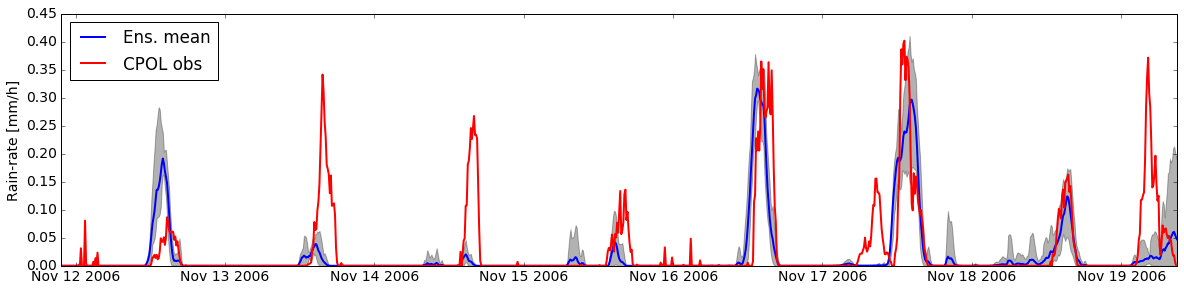

In [158]:
T = times[:].tz_localize(utc).tz_convert(timezone).to_pydatetime()
fig = plt.figure(figsize=(20,10), dpi=72)
ax = fig.add_subplot(111)
ax.fill_between(T[:-1],ens_ts.min(axis=0),ens_ts.max(axis=0), color = 'k', alpha=0.3)
ax.plot(T[:-1],ens_ts.mean(axis=0),color='b', label='Ens. mean', lw=2)
ax.plot(T[:-1], DF['CPOL'][1:], color='r', label='CPOL obs', lw=2)
ax.legend(loc=0)
ax.set_ylabel('Rain-rate [mm/h]')
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)
fig.savefig(os.path.join(os.getenv('HOME'), 'Ens_run'), bbox_inches='tight', format='png', dpi=72)